
This is an interactive tutorial designed to walk through
regularization for a linear-Gaussian GLM, which allows for closed-form
MAP parameter estimates.  The next tutorial ('tutorial4') will cover the
same methods for the Poisson GLM (which requires numerical optimization).

We'll consider two simple regularization methods:

1. Ridge regression - corresponds to maximum a posteriori (MAP) estimation under an iid Gaussian prior on the filter coefficients. 

2. L2 smoothing prior - using to an iid Gaussian prior on the pairwise-differences of the filter(s).

Data: from Uzzell & Chichilnisky 2004; see README file for details. 

Last updated: Mar 10, 2020 (JW Pillow)

Tutorial instructions: Execute each section below separately using
cmd-enter. For detailed suggestions on how to interact with this
tutorial, see header material in tutorial1_PoissonGLM.m

Transferred into Python by Xiaodong LI

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.linalg import hankel,pinv,block_diag
from scipy.interpolate import interp1d
from interpolation import interp
from numpy.linalg import inv,norm,lstsq
from matplotlib import mlab

aa=np.asarray

def neglogli_poissGLM(prs,XX,YY,dtbin):
    """
    Compute negative log-likelihood of data undr Poisson GLM model with
    exponential nonlinearity
    
    Inputs:
      prs [d x 1] - parameter vector
       XX [T x d] - design matrix
       YY [T x 1] - response (spike count per time bin)
    dtbin [1 x 1] - time bin size used 
    
    Outputs:
      neglogli   = negative log likelihood of spike train
      dL [d x 1] = gradient 
      H  [d x d] = Hessian (second deriv matrix)
    """
    # Compute GLM filter output and condititional intensity
    vv = XX@prs # filter output
    rr = np.exp(vv)*dtbin # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T@YY # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term 
    neglogli = Trm1 + Trm0
    
    return neglogli

def jac_neglogli_poissGLM(prs,XX,YY,dtbin):
    
    # Compute GLM filter output and condititional intensity
    vv = XX@prs # filter output
    rr = np.exp(vv)*dtbin # conditional intensity (per bin)
    
    # ---------  Compute Gradient -----------------
    dL1 = -XX.T@YY # spiking term (the spike-triggered average)
    dL0 = XX.T@rr # non-spiking term
    dL = dL1+dL0
    
    return dL

def hess_neglogli_poissGLM(prs,XX,YY,dtbin):
    # Compute GLM filter output and condititional intensity
    vv = XX@prs # filter output
    rr = np.exp(vv)*dtbin # conditional intensity (per bin)
    # ---------  Compute Hessian -------------------
    H = XX.T@np.multiply(XX,rr.reshape(-1,1)) # non-spiking term
    
    return H

def neglogposterior(prs,negloglifun,Cinv):
    """
    Compute negative log-posterior given a negative log-likelihood function 
    and zero-mean Gaussian prior with inverse covariance 'Cinv'.

    Inputs:
       prs [d x 1] - parameter vector
       negloglifun - handle for negative log-likelihood function
      Cinv [d x d] - response (spike count per time bin)

    Outputs:
      negLP - negative log posterior
      grad [d x 1] - gradient 
         H [d x d] - Hessian (second deriv matrix)

    Compute negative log-posterior by adding quadratic penalty to log-likelihood
    """

    # evaluate function and gradient
    negLP= negloglifun(prs)
    negLP += .5*prs.T@Cinv@prs        
    return negLP
def jac_neglogposterior(prs,jac_negloglifun,Cinv):
    grad=jac_negloglifun(prs)
    grad += Cinv@prs
    return grad
def hess_neglogposterior(prs,hess_negloglifun,Cinv):
    H=hess_negloglifun(prs)
    H += Cinv
    return H

# Load the raw data

Be sure to unzip the data file data_RGCs.zip
(http://pillowlab.princeton.edu/data/data_RGCs.zip) and place it in 
this directory before running the tutorial.  
Or substitute your own dataset here instead!


(Data from Uzzell & Chichilnisky 2004):

In [31]:
datadir='../data_RGCs/' # directory where stimulus lives
Stim=loadmat(datadir+'Stim.mat')['Stim'].flatten() # stimulus (temporal binary white noise)
stimtimes=loadmat(datadir+'stimtimes.mat')['stimtimes'].flatten() # stim frame times in seconds (if desired)
SpTimes=loadmat(datadir+'SpTimes.mat')['SpTimes'][0,:] # load spike times (in units of stim frames)
ncells=len(SpTimes) # number of neurons (4 for this dataset).
# Neurons #0-1 are OFF, #2-3 are ON.

Pick a cell to work with

In [32]:
cellnum = 2 # (0-1 are OFF cells; 2-3 are ON cells).
tsp = SpTimes[cellnum];

Compute some basic statistics on the stimulus

In [33]:
dtStim = stimtimes[1]-stimtimes[0] # time bin size for stimulus (s)

# See tutorial 1 for some code to visualize the raw data!

# Upsample to get finer timescale representation of stim and spikes

The need to regularize GLM parameter estimates is acute when we don't
have enough data relative to the number of parameters we're trying to
estimate, or when using correlated (eg naturalistic) stimuli, since the
stimuli don't have enough power at all frequencies to estimate all
frequency components of the filter. 

The RGC dataset we've looked at so far requires only a temporal filter
(as opposed to spatio-temporal filter for full spatiotemporal movie
stimuli), so it doesn't have that many parameters to esimate. It also has
binary white noise stimuli, which have equal energy at all frequencies.
Regularization thus isn't an especially big deal for this data (which was
part of our reason for selecting it). However, we can make it look
correlated by considering it on a finer timescale than the frame rate of
the monitor.  (Indeed, this will make it look highly correlated).

For speed of our code and to illustrate the advantages of regularization,
let's use only a reduced (5-minute) portion of the dataset:

In [34]:
nT=120*60*1 # # of time bins for 1 minute of data
Stim=Stim[:nT] # pare down stimulus
tsp=tsp[tsp<nT*dtStim] # pare down spikes

Now upsample to finer temporal grid

In [35]:
upsampfactor = 5 # divide each time bin by this factor
dtStimhi = dtStim/upsampfactor # use bins 100 time bins finer
ttgridhi = np.arange(dtStimhi/2,nT*dtStim+dtStimhi,dtStimhi) # fine time grid for upsampled stim
Stimhi = interp1d(np.arange(1,nT+1)*dtStim,Stim,kind='nearest',fill_value='extrapolate')(ttgridhi)
nThi = nT*upsampfactor  # length of upsampled stimulus

Visualize the new (upsampled) raw data:

<ipython-input-36-97db7153fd27>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes[1].stem(ttplot,sps[iiplot])


(0.0, 0.498768179)

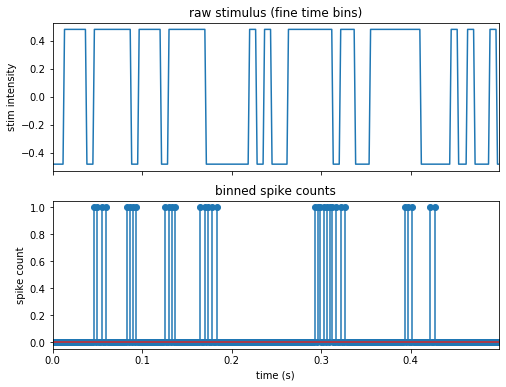

In [36]:
fig,axes=plt.subplots(nrows=2,figsize=(8,6),sharex=True)
iiplot=np.arange(0,60*upsampfactor) # bins of stimulus to plot
ttplot=iiplot*dtStimhi # time bins of stimulus
axes[0].plot(ttplot,Stimhi[iiplot])
axes[0].set_title('raw stimulus (fine time bins)')
axes[0].set_ylabel('stim intensity')
# Should notice stimulus now constant for many bins in a row
sps,_=np.histogram(tsp,ttgridhi) # Bin the spike train and replot binned counts
axes[1].stem(ttplot,sps[iiplot])
axes[1].set_title('binned spike counts')
axes[1].set_ylabel('spike count')
axes[1].set_xlabel('time (s)')
axes[1].set_xlim(ttplot[0],ttplot[-1])

# Divide data into "training" and "test" sets for cross-validation

In [37]:
trainfrac = .8  # fraction of data to use for training
ntrain = int(np.ceil(nThi*trainfrac))  # number of training samples
ntest = int(nThi-ntrain) # number of test samples
iitest = np.arange(ntest).astype(int) # time indices for test
iitrain = np.arange(ntest,nThi).astype(int)   # time indices for training
stimtrain = Stimhi[iitrain] # training stimulus
stimtest = Stimhi[iitest] # test stimulus
spstrain = sps[iitrain]
spstest =  sps[iitest]

print('Dividing data into training and test sets:\n')
print('Training: %d samples (%d spikes) \n'%(ntrain, sum(spstrain)))
print('    Test: %d samples (%d spikes)\n'%(ntest, sum(spstest)))

Dividing data into training and test sets:

Training: 28800 samples (2109 spikes) 

    Test: 7200 samples (557 spikes)



Set the number of time bins of stimulus to use for predicting spikes

In [38]:
ntfilt = 20*upsampfactor # Try varying this, to see how performance changes!

build the design matrix, training data

In [39]:
Xtrain = np.c_[
    np.ones((ntrain,1)),
    hankel(np.r_[np.zeros(ntfilt-1),stimtrain[:-ntfilt+1]].reshape(-1,1),stimtrain[-ntfilt:])]

Build design matrix for test data

In [40]:
Xtest = np.c_[
    np.ones((ntest,1)),
    hankel(np.r_[np.zeros(ntfilt-1),stimtest[:-ntfilt+1]].reshape(-1,1),stimtest[-ntfilt:])]

# Fit poisson GLM using ML

Compute maximum likelihood estimate (using `scipy.optimize.fmin` instead of `sm.GLM`)

In [41]:
sta = (Xtrain.T@spstrain)/np.sum(spstrain) # compute STA for initialization

Make loss function and minimize

In [51]:
jac_neglogli_poissGLM?

Text(0.5, 1.0, 'Maximum likelihood filter estimate')

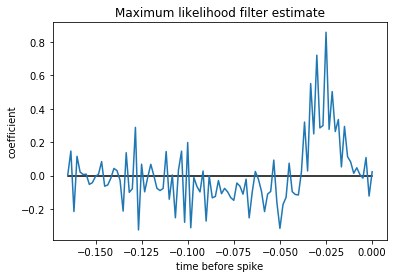

In [58]:
lossfun=lambda prs:neglogli_poissGLM(prs,Xtrain,spstrain,dtStimhi)
jacfun=lambda prs:jac_neglogli_poissGLM(prs,Xtrain,spstrain,dtStimhi)
hessfun=lambda prs:hess_neglogli_poissGLM(prs,Xtrain,spstrain,dtStimhi)
filtML=minimize(lossfun,x0=sta,method='trust-ncg',jac=jacfun, hess=hessfun).x

ttk=np.arange(-ntfilt+1,1)*dtStimhi
fig,axes=plt.subplots()
axes.plot(ttk,ttk*0,'k')
axes.plot(ttk,filtML[1:])
axes.set_xlabel('time before spike')
axes.set_ylabel('coefficient')
axes.set_title('Maximum likelihood filter estimate')
# % Looks bad due to lack of regularization!

# Ridge regression prior

<img src='pics/f4-1.png'>

Now let's regularize by adding a penalty on the sum of squared filter
coefficients w(i) of the form:
    
      penalty(lambda) = lambda*(sum_i w(i).^2),

where lambda is known as the "ridge" parameter.  As noted in tutorial3,
this is equivalent to placing an iid zero-mean Gaussian prior on the RF
coefficients with variance equal to 1/lambda. Lambda is thus the inverse
variance or "precision" of the prior.

To set lambda, we'll try a grid of values and use
cross-validation (test error) to select which is best.  

Set up grid of lambda values (ridge parameters)

In [59]:
lamvals = 2.**np.arange(0,11,1) # it's common to use a log-spaced set of values
nlam = len(lamvals)

Precompute some quantities (X'X and X'*y) for training and test data

In [60]:
Imat = np.eye(ntfilt+1) # identity matrix of size of filter + const
Imat[0,0] = 0 # remove penalty on constant dc offset

Allocate space for train and test errors

In [62]:
negLtrain = np.zeros(nlam) # training error
negLtest = np.zeros(nlam) # test error
w_ridge = np.zeros((ntfilt+1,nlam)) # filters for each lambda

Define train and test log-likelihood funcs

In [72]:
negLtrainfun = lambda prs:neglogli_poissGLM(prs,Xtrain,spstrain,dtStimhi)
jac_negLtrainfun = lambda prs:jac_neglogli_poissGLM(prs,Xtrain,spstrain,dtStimhi)
hess_negLtrainfun = lambda prs:hess_neglogli_poissGLM(prs,Xtrain,spstrain,dtStimhi)
negLtestfun = lambda prs:neglogli_poissGLM(prs,Xtest,spstest,dtStimhi)
jac_negLtestfun = lambda prs:jac_neglogli_poissGLM(prs,Xtest,spstest,dtStimhi)
hess_negLtestfun = lambda prs:hess_neglogli_poissGLM(prs,Xtest,spstest,dtStimhi)

Now compute MAP estimate for each ridge parameter

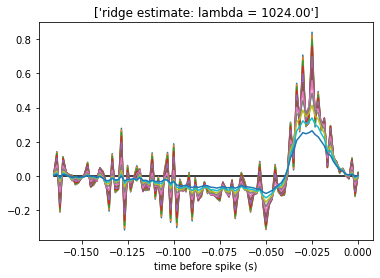

In [74]:
wmap = filtML # initialize parameter estimate
fig,axes=plt.subplots()
axes.plot(ttk,ttk*0,'k') # initialize plot
for jj in range(nlam):
    
    # Compute ridge-penalized MAP estimate
    Cinv = lamvals[jj]*Imat # set inverse prior covariance
    lossfun = lambda prs:neglogposterior(prs,negLtrainfun,Cinv)
    jacfun=lambda prs:jac_neglogposterior(prs,jac_negLtrainfun,Cinv)
    hessfun=lambda prs:hessian_neglogposterior(prs,hess_negLtrainfun,Cinv)
    
    wmap=minimize(lossfun,x0=wmap,method='trust-ncg',jac=jacfun,hess=hessfun).x
     
    # Compute negative logli
    negLtrain[jj] = negLtrainfun(wmap) # training loss
    negLtest[jj] = negLtestfun(wmap) # test loss
    
    # store the filter
    w_ridge[:,jj] = wmap
    
    # plot it
    axes.plot(ttk,wmap[1:]) 
    axes.set_title(['ridge estimate: lambda = %.2f'%lamvals[jj]])
    axes.set_xlabel('time before spike (s)')
 # note that the esimate "shrinks" down as we increase lambda

Plot filter estimates and errors for ridge estimates

Text(0.5, 1.0, 'best ridge estimate')

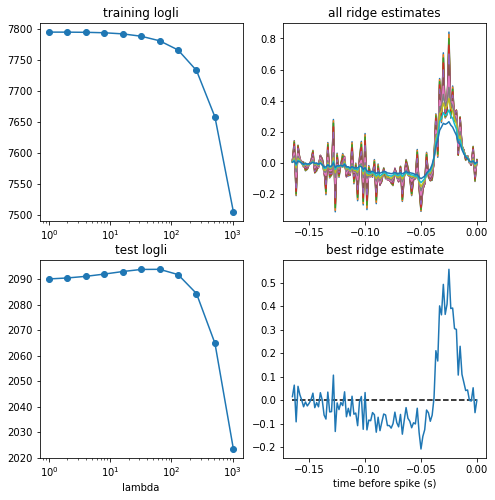

In [76]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(8,8))
axes[0,1].plot(ttk,w_ridge[1:,:])
axes[0,1].set_title('all ridge estimates')
axes[0,0].semilogx(lamvals,-negLtrain,'o-')
axes[0,0].set_title('training logli')
axes[1,0].semilogx(lamvals,-negLtest,'o-')
axes[1,0].set_title('test logli')
axes[1,0].set_xlabel('lambda')

# Notice that training error gets monotonically worse as we increase lambda
# However, test error has an dip at some optimal, intermediate value.

# Determine which lambda is best by selecting one with lowest test error 
imin = np.argmin(negLtest)
filt_ridge= w_ridge[1:,imin]

axes[1,1].plot(ttk,ttk*0, 'k--') 
axes[1,1].set_xlabel('time before spike (s)')
axes[1,1].set_title('best ridge estimate')

# L2 smoothing prior

<img src='pics/f4-2.png'>

Use penalty on the squared differences between filter coefficients,
penalizing large jumps between successive filter elements. This is
equivalent to placing an iid zero-mean Gaussian prior on the increments
between filter coeffs.  (See tutorial 3 for visualization of the prior
covariance).

This matrix computes differences between adjacent coeffs

In [77]:
Dx1 = (np.diag(-np.ones(ntfilt),0)+np.diag(np.ones(ntfilt-1),1))[:-1,:]
Dx = Dx1.T@Dx1 # computes squared diffs

Select smoothing penalty by cross-validation

In [78]:
lamvals = 2**np.arange(1,15) # grid of lambda values (ridge parameters)
nlam = len(lamvals)

Embed `Dx` matrix in matrix with one extra row/column for constant coeff

In [79]:
D = block_diag(0,Dx)

Allocate space for train and test errors

In [81]:
negLtrain_sm = np.zeros(nlam) # training error
negLtest_sm = np.zeros(nlam) # test error
w_smooth = np.zeros((ntfilt+1,nlam)) # filters for each lambda

Now compute MAP estimate for each ridge parameter

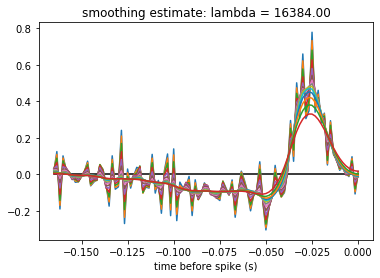

In [84]:
fig,axes=plt.subplots()
axes.plot(ttk,ttk*0,'k') # initialize plot
wmap=filtML # initialize with ML fit
for jj in range(nlam):
    
    # Compute MAP estimate
    Cinv=lamvals[jj]*D # set inverse prior covariance
    lossfun = lambda prs:neglogposterior(prs,negLtrainfun,Cinv)
    jacfun=lambda prs:jac_neglogposterior(prs,jac_negLtrainfun,Cinv)
    hessfun=lambda prs:hessian_neglogposterior(prs,hess_negLtrainfun,Cinv)
    wmap=minimize(lossfun,x0=wmap,method='trust-ncg',jac=jacfun,hess=hessfun).x
    
    # Compute negative logli
    negLtrain_sm[jj]=negLtrainfun(wmap) # training loss
    negLtest_sm[jj]=negLtestfun(wmap) # test loss
        
    # store the filter
    w_smooth[:,jj] = wmap
    
    # plot it
    axes.plot(ttk,wmap[1:]) 
    axes.set_title('smoothing estimate: lambda = %.2f'%lamvals[jj])
    axes.set_xlabel('time before spike (s)')

Plot filter estimates and errors for smoothing estimates

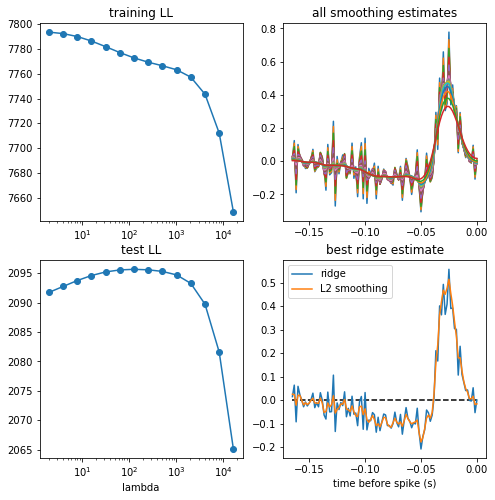

In [89]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(8,8))
axes[0,1].plot(ttk,w_smooth[1:,:])
axes[0,1].set_title('all smoothing estimates')
axes[0,0].semilogx(lamvals,-negLtrain_sm,'o-')
axes[0,0].set_title('training LL')
axes[1,0].semilogx(lamvals,-negLtest_sm,'o-')
axes[1,0].set_title('test LL')
axes[1,0].set_xlabel('lambda')

# Notice that training error gets monotonically worse as we increase lambda
# However, test error has an dip at some optimal, intermediate value.

# Determine which lambda is best by selecting one with lowest test error 
imin = np.argmin(negLtest_sm)
filt_smooth= w_smooth[1:,imin]

axes[1,1].plot(ttk,ttk*0, 'k--') 
axes[1,1].plot(ttk,filt_ridge,label='ridge')
axes[1,1].plot(ttk,filt_smooth,label='L2 smoothing')
axes[1,1].set_xlabel('time before spike (s)')
axes[1,1].set_title('best ridge estimate')
axes[1,1].legend()

# clearly the "L2 smoothing" filter looks better by eye!

Last, lets see which one actually achieved lower test error

In [90]:
print('\nBest ridge test error:      %.5f'%(-min(negLtest)))
print('Best smoothing test error:  %.5f'%(-min(negLtest_sm)))


Best ridge test error:      2093.80432
Best smoothing test error:  2095.67887


Advanced exercise:
--------------------

1. Repeat of the above, but incorporate spike history filters as in tutorial2. Use a different smoothing hyperparamter for the spike-history / coupling filters than for the stim filter. In this case one needs to build a block diagonal prior covariance, with one block for each group of coefficients.